<a href="https://colab.research.google.com/github/farukemrekaraca/ztm-tensorflow-machinelearning-deeplearning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!nvidia-smi

Tue Feb  6 14:37:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-06 14:37:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-06 14:37:40 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
from helper_functions import *

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2024-02-06 14:37:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.114.207, 172.253.119.207, 108.177.111.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.114.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   137MB/s    in 9.3s    

2024-02-06 14:37:53 (166 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [8]:
unzip_data("101_food_classes_10_percent.zip")

In [9]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [10]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/poutine'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lasagna'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pork_chop'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/samosa'.
There are 0 directories and 75 images in '101_food_classes

In [11]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [12]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor="val_accuracy")

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [14]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

input = layers.Input(shape=(224, 224, 3))
x = data_augmentation(input)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
output = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(input, output)

24274472/24274472 [==============================] - 0s 0us/step


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [16]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [37]:
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                          epochs=5,
                                          validation_data=test_data,
                                          validation_steps=int(0.15 * len(test_data)),
                                          callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 198s 797ms/step - loss: 3.5406 - accuracy: 0.2318 - val_loss: 2.7051 - val_accuracy: 0.4113
Epoch 2/5
237/237 [==============================] - 131s 546ms/step - loss: 2.4227 - accuracy: 0.4461 - val_loss: 2.1830 - val_accuracy: 0.4955
Epoch 3/5
237/237 [==============================] - 111s 468ms/step - loss: 2.0500 - accuracy: 0.5238 - val_loss: 1.9696 - val_accuracy: 0.5209
Epoch 4/5
237/237 [==============================] - 92s 387ms/step - loss: 1.8475 - accuracy: 0.5472 - val_loss: 1.8672 - val_accuracy: 0.5376
Epoch 5/5
237/237 [==============================] - 89s 375ms/step - loss: 1.6943 - accuracy: 0.5857 - val_loss: 1.7807 - val_accuracy: 0.5498


In [38]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 49s 62ms/step - loss: 1.6263 - accuracy: 0.5748


[1.6263316869735718, 0.574772298336029]

In [17]:
unzip_data("101_classes_10_percent_data_model_checkpoint.zip")

In [21]:
model.load_weights("101_classes_10_percent_data_model_checkpoint")

In [22]:
model.evaluate(test_data)

790/790 [==============================] - 56s 63ms/step - loss: 1.6174 - accuracy: 0.5749


[1.6174368858337402, 0.5748910903930664]

In [ ]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

input = layers.Input(shape=(224, 224, 3))
x = data_augmentation(input)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
output = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

test_model = tf.keras.Model(input, output)

In [ ]:
test_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
test_model.evaluate(test_data)

790/790 [==============================] - 60s 72ms/step - loss: 4.7153 - accuracy: 0.0072


[4.7153496742248535, 0.007247524801641703]

In [ ]:
test_model.load_weights("101_classes_10_percent_data_model_checkpoint")

In [ ]:
test_model.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 1.6174 - accuracy: 0.5749


[1.6174368858337402, 0.5748910903930664]

Model can evidently be recovered and fitting phase can be skipped after google colab session is reset if the weights have been saved. ModelCheckpoint can be used towards this goal. The checpoint files generated by the code must be downloaded to local computer or saved to drive and in the next session the model only needs to be compiled and then the weights loaded from the saved file, which can be uploaded from local drive/google drive to google colab.

In [24]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [25]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [26]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_2 True
data_augmentation True
efficientnetv2-b0 True
global_avg_pool_layer True
output_layer True


In [29]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [41]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 73s 304ms/step - loss: 1.4804 - accuracy: 0.6325 - val_loss: 1.7334 - val_accuracy: 0.5551
Epoch 6/10
237/237 [==============================] - 62s 261ms/step - loss: 1.4015 - accuracy: 0.6512 - val_loss: 1.7032 - val_accuracy: 0.5583
Epoch 7/10
237/237 [==============================] - 64s 269ms/step - loss: 1.3405 - accuracy: 0.6630 - val_loss: 1.7164 - val_accuracy: 0.5519
Epoch 8/10
237/237 [==============================] - 60s 253ms/step - loss: 1.2840 - accuracy: 0.6785 - val_loss: 1.7094 - val_accuracy: 0.5508
Epoch 9/10
237/237 [==============================] - 54s 225ms/step - loss: 1.2214 - accuracy: 0.6903 - val_loss: 1.6682 - val_accuracy: 0.5596
Epoch 10/10
237/237 [==============================] - 52s 218ms/step - loss: 1.1727 - accuracy: 0.7027 - val_loss: 1.6536 - val_accuracy: 0.5646


In [43]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 50s 63ms/step - loss: 1.4917 - accuracy: 0.6008


[1.4916620254516602, 0.6007920503616333]

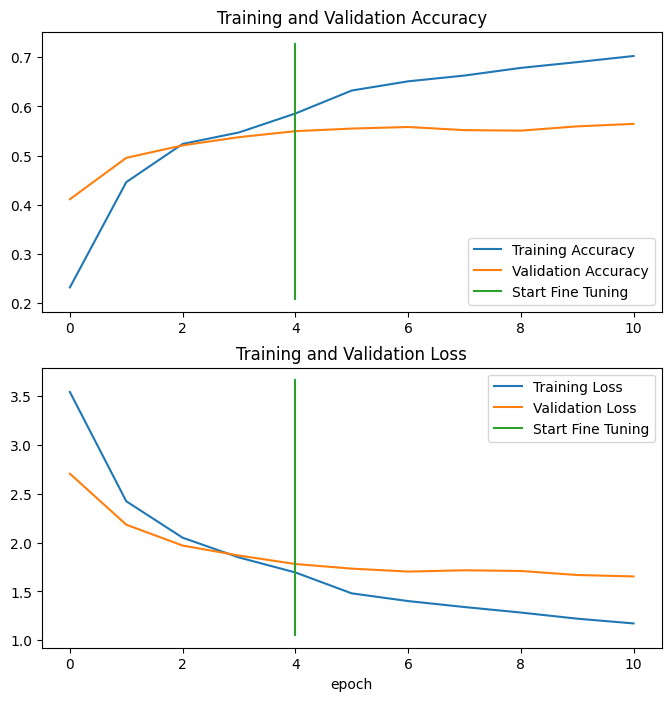

In [44]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [ ]:
model.save("drive/MyDrive/tensorflow/101_food_classes_10_percent_saved_big_model")

In [ ]:
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow/101_food_classes_10_percent_saved_big_model")

In [48]:
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 55s 69ms/step - loss: 1.4917 - accuracy: 0.6008


In [50]:
all_classes_10_percent_fine_tune_results == loaded_model_results

True

In [18]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-02-06 14:39:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.207, 74.125.201.207, 74.125.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M   240MB/s    in 0.2s    

2024-02-06 14:39:00 (240 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [19]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [20]:
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [56]:
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 60s 73ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

In [21]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 66s 77ms/step


In [58]:
len(preds_probs)

25250

In [60]:
preds_probs.shape

(25250, 101)

In [61]:
preds_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [63]:
preds_probs[0]

array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
       8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
       1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
       2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
       6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
       1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
       8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
       2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
       1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
       1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
       8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
       2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
       3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
       8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.74041920e-05,
      

In [64]:
len(preds_probs[0])

101

In [66]:
preds_probs[0].argmax()

52

In [65]:
preds_probs[0][52]

0.8474181

In [75]:
test_data.class_names[52]

'gyoza'

In [22]:
pred_classes = preds_probs.argmax(axis=1)

pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [23]:
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [76]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [24]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [79]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20)

In [1]:
def load_and_prep_image(filename, img_shape=224, scale=True):

  img = tf.io.read_file(filename)

  img = tf.io.decode_image(img, channels=3)

  img = tf.image.resize(img, [img_shape, imh_shape])

  if scale:
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 28ms/step


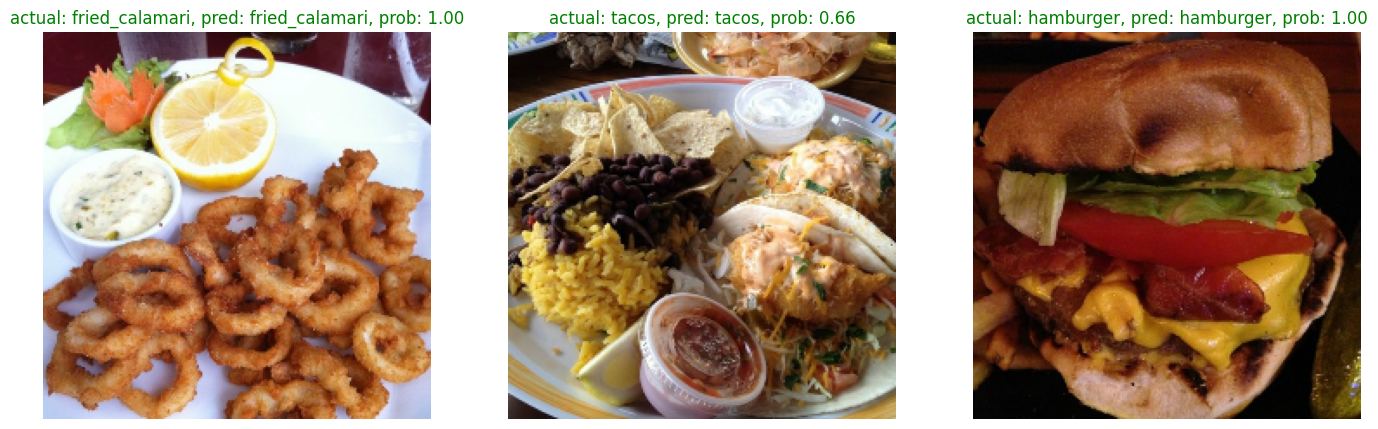

In [33]:
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)

  if class_name == pred_class:
    title_color="g"
  else:
    title_color="r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);